----
# Data Augmentation of MNIST Dataset
----
In this notebook, I will explore the different data augmentation techniques to use on the MNIST dataset using ImageDataGenerator from Keras.
Data augmentation allows noise to be introduced into the dataset with using data already present, by applying this dataset to models it helps thier ability to genrelise to unseen real data (which usually has more noise).

#### Key Objectives:
- **Apply Data Augmentation**: Use Keras to create augmentations of the MNIST data such as rotations, shifts, flips, and zooms.
- **Visualize Augmented Data**: Display examples of augmented images to understand the effects of different augmentation techniques.
- **Prepare Augmented Dataset**: Generate a new, augmented dataset that can be used to train the models.

## Set Up
----

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import random

import joblib
import math


In [2]:
tf.random.set_seed(1)
np.random.seed(1)

## Data Loading
-----

In [3]:
# Both to be used at a later time to assign meaningful values to the nuermic target class
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

In [4]:
# load X and y
X  = joblib.load('../../data/my_data/X.pkl' )
y = joblib.load('../../data/my_data/y.pkl' )

In [5]:
# split X and y into train/val datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1)

In [6]:
# rehshaping X vars to have 4 dimensions (num_imgs, height, width, channel)
X_train = X_train.reshape(X_train.shape[0], 28,28,-1)
X_val = X_val.reshape(X_val.shape[0], 28,28,-1)

## Utility Functions
-----

In [7]:
def testing_aug_effects(X,letter, aug_param , aug_value):
    '''
    Overview:
    To visualise the effects of each augmentation parameter for a given letter


    Arguments:
        - X -> Input data
        - letter -> Letter (NOT J/Z as both of these letters do not exist in dataset)
        - aug_param -> Out of one of the following [rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, horizontal_flip]
        - aug_value -> Amount of augmentation to be applied

    Output:
        - 2 figures:
            - input image of letter
            - input image with given augmentatation parameter applied

    '''   

    X = X.reshape(-1,28,28)
    letter_idx = alphabet.index(letter.lower())
    my_input_img = X[y==letter_idx][0].reshape(-1,28,28,1)
    
    
    if letter.lower() in ('j', 'z'):
        raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:

        letter_idx = alphabet.index(letter.lower())

        # Initialize ImageDataGenerator with appropriate augmentations
        testing_aug_effects = ImageDataGenerator(
            rescale=1./255,
            rotation_range=aug_value if aug_param == 'rotation_range' else 0,
            width_shift_range=aug_value if aug_param == 'width_shift_range' else 0,
            height_shift_range=aug_value if aug_param == 'height_shift_range' else 0,
            shear_range=aug_value if aug_param == 'shear_range' else 0,
            zoom_range=aug_value if aug_param == 'zoom_range' else 0,
            horizontal_flip=aug_value if aug_param == 'horizontal_flip' else False,
            fill_mode='nearest'
        )

        # shuffle = False -> same input iamge [0] used for each batch 
        # batch_size to 1 -> each batch only contains one image
        aug_iamge = testing_aug_effects.flow(my_input_img, shuffle= False, batch_size=1)

        # using .next to see variants of augmentation on same image (need to rerun the function to show this)
        augmented_image = next(aug_iamge)[0]

        # since .next will include non-augmented images we need to filter these out
        # using np/array_equal to only bring back augmented images where augmented images do not equal the input image
        if not np.array_equal(my_input_img[0], augmented_image): 
            plt.subplots(1,2, figsize =(10,10))
            plt.subplot(1,2,1)
            plt.imshow(X[y==letter_idx][0],cmap='gray')
            plt.title(f'Original Input Image {letter.upper()}')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(1,2,2)
            plt.imshow(augmented_image.reshape(28,28),cmap='gray')
            plt.title(f'Adjusting {aug_param} to {aug_value}')
            plt.xticks([])
            plt.yticks([])
            plt.show()


## Data Augmentation
----

### Visualising effect of each data augmentation param

- rotation_range
    - Example: rotation_range=20 means the image can be randomly rotated between -20 to +20 degrees.
- width_shift_range
    - Example: width_shift_range=0.2 means the image can be shifted horizontally by up to 20% of its width.
- height_shift_range
    - Example: height_shift_range=0.1 means the image can be shifted vertically by up to 10% of its height
- shear_range
    - Example: shear_range=0.2 means the image will be sheared by up to 20%.
- zoom_range
    - Example: zoom_range=0.2 means the image will be zoomed in or out by up to 20%.
- horizontal_flip
    - Example: horizontal_flip=True means images will be randomly flipped horizontally.

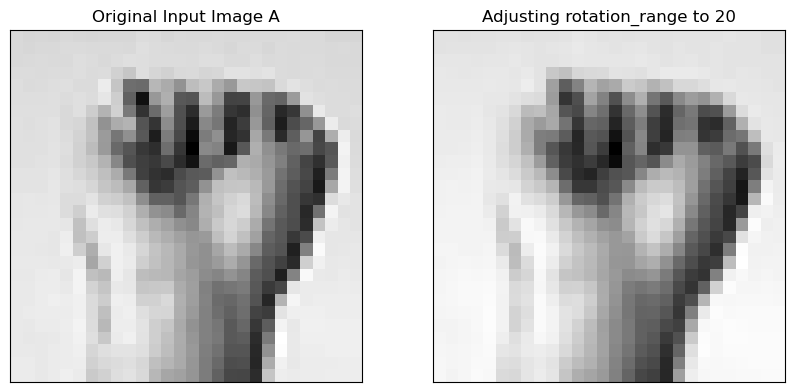

In [8]:
testing_aug_effects(X,'A',aug_param= 'rotation_range', aug_value = 20)

### Choosing approprate augmentation for sign language

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(rescale=1./255)

Why I decided to settle on the augmentation above:
- rescale=1./255 ============> Normalisation of the input data is best when working with neural networks
- rotation_range=20 =========> To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1 =====> To ensure model is able to deal with off-centered images
- height_shift_range=0.1 ====> To ensure model is able to deal with off-centered images
- shear_range=0.2 ===========> To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2 ============> Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=True =====>  To mimic opposite hand, if original image is left hand we can flip the image to show right hand

NOTE: Not all images will be augmeted, ImageDataGenerator and .flow ensures augmentation is only done to some randomly selected images
      Not all augmnetation techniques will be applied to each image, the augmentation method applied to an image is randomly selected.

In [10]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

## Visualising Augmentation
----

In [11]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values = np.unique(y_train)

In [12]:
# Plotting augmentation
fig, axes = plt.subplots(4,3, figsize=(80, 120))

for target, ax in zip(unique_values, axes.ravel()):
    ax.imshow(X_train[y_train==target][0], cmap= 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)

    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Pikling of train and val generators
----

In [13]:
joblib.dump(train_datagen,'../../data/my_data/train_datagen.pkl') # saving augmentation of train data now we can call this for nets
joblib.dump(val_datagen,'../../data/my_data/val_datagen.pkl')

['../../data/my_data/val_datagen.pkl']

## Pikling augmented data for linear models
---

In [14]:
# Number of batches to process to cover the entire dataset
num_batches = len(X_train)/32

In [15]:
# Initialize arrays to store the augmented data
X_train_aug= []
y_train_aug = []

In [16]:
# to update method of creating aug_training dataset
for batch in range(math.ceil(num_batches)):
    X_train_a, y_train_a = next(train_generator)
    X_train_aug.append(X_train_a)
    y_train_aug.append(y_train_a)


In [17]:
# to update method of creating aug_training dataset
X_val_aug= []
y_val_aug = []

for batch in range(math.ceil(num_batches)):
    X_val_a, y_val_a = next(val_generator)
    X_val_aug.append(X_val_a)
    y_val_aug.append(y_val_a)

In [18]:
joblib.dump(X_train_aug,'../../data/my_data/X_train_aug.pkl')
joblib.dump(y_train_aug,'../../data/my_data/y_train_aug.pkl')
joblib.dump(X_val_aug,'../../data/my_data/X_val_aug.pkl')
joblib.dump(y_val_aug,'../../data/my_data/y_val_aug.pkl')

['../../data/my_data/y_val_aug.pkl']

## Conclusion
----



Augmenting the images will introduce some noise and variability into the data set to mimic the real world where pictures are not centered, have a clear definition, etc. By training models on augmented dataset allow models to become more robust and generalise better.